In [ ]:
import random; from IPython.display import display,HTML
from IPython.core.magic import register_line_magic
@register_line_magic
def radial_gradient_header(params):
    randi=str(random.randint(1,9999999))
    params=params.split('|'); string=params[0]
    if len(params)==1: 
        font_size=str(30); font_family='Ewert'
    elif len(params)==2: 
        font_size=params[1]; font_family='Ewert'
    else:
        font_size=params[1]; font_family=params[2]
    html_str="""<style>@import 'https://fonts.googleapis.com/css?"""+\
    """family="""+font_family+"""'; #div"""+randi+\
    """ {background:white; padding:2px;}
    .textrg {display:inline-block; font-size:"""+font_size+\
    """px; line-height:1.1; padding:5px; font-family:"""+font_family+\
    """,sans-serif; text-transform:uppercase;
       background:radial-gradient(
           circle farthest-corner at center center,
           orange,magenta,cyan) no-repeat;
       -webkit-background-clip:text;
       -webkit-text-fill-color:transparent;}</style>
    <div id='div"""+randi+"""'><text class='textrg'>"""+string+\
    """</text></div>"""
    display(HTML(html_str))

In [3]:
import warnings; warnings.filterwarnings('ignore')
import pandas as pd,numpy as np
import pylab as pl,tensorflow as tf
from sklearn import datasets
import sklearn.model_selection as sms
from tensorflow.data import Dataset as tds

In [4]:
def pd_style():
    return [dict(selector='th',
                 props=[('font-size','10pt'),('min-width','45px')]),
            dict(selector='td',
                 props=[('padding','0em 0em'),('min-width','45px')]),
            dict(selector='tr:hover th:hover',
                 props=[('font-size','11pt'),('max-width','45px'),
                        ('text-shadow','3px 3px 3px #aaa')]),
            dict(selector='tr:hover td:hover',
                 props=[('font-size','10pt'),('max-width','45px'),
                        ('text-shadow','3px 3px 3px #aaa')])]

In [5]:
%radial_gradient_header Data Exploration

In [6]:
boston_data=datasets.load_boston()
columns=boston_data.feature_names
boston_df=pd.DataFrame(boston_data.data,columns=columns)
boston_df['MEDV']=boston_data.target
boston_df[['CHAS','RAD']]=boston_df[['CHAS','RAD']].astype('int64')
numeric_features=\
boston_df.columns[[0,2,4,5,6,7,9,10,11,12,13]]
stats=boston_df.describe().transpose()
dfn=boston_df.copy()
for nc in numeric_features:
    mean=stats.loc[nc,'mean']; std=stats.loc[nc,'std']
    dfn.loc[:,nc]=(dfn.loc[:,nc]-mean)/std
dfn[numeric_features].tail(int(10)).style.bar(
    align='mid',color=['#55eeee','#ee55ee'],
    subset=numeric_features).set_precision(3)\
   .set_table_styles(pd_style())

,CRIM,INDUS,NOX,RM,AGE,DIS,TAX,PTRATIO,B,LSTAT,MEDV
496,-0.386,-0.211,0.262,-1.273,0.154,-0.473,-0.102,0.344,0.441,1.188,-0.308
497,-0.389,-0.211,0.262,-0.698,0.072,-0.429,-0.102,0.344,0.441,0.203,-0.460
498,-0.392,-0.211,0.262,-0.378,-0.116,-0.658,-0.102,0.344,0.441,0.037,-0.145
499,-0.399,-0.211,0.262,-1.019,0.175,-0.663,-0.102,0.344,0.428,0.343,-0.547
500,-0.394,-0.211,0.262,-0.367,0.395,-0.616,-0.102,0.344,0.441,0.235,-0.623
501,-0.413,0.116,0.158,0.439,0.019,-0.625,-0.802,1.175,0.387,-0.418,-0.014
502,-0.415,0.116,0.158,-0.234,0.289,-0.716,-0.802,1.175,0.441,-0.500,-0.210
503,-0.413,0.116,0.158,0.984,0.797,-0.773,-0.802,1.175,0.441,-0.982,0.149
504,-0.407,0.116,0.158,0.725,0.736,-0.668,-0.802,1.175,0.403,-0.864,-0.058
505,-0.415,0.116,0.158,-0.362,0.434,-0.613,-0.802,1.175,0.441,-0.668,-1.156


In [7]:
%radial_gradient_header Data Processing

In [8]:
tfnumeric_features=[]
for nc in numeric_features[:-1]:
    tfnumeric_features.append(
        tf.feature_column.numeric_column(key=nc)) 
for nf in tfnumeric_features: 
    print(str(nf)); break
fchas=tf.feature_column\
.categorical_column_with_vocabulary_list(
    key='CHAS',vocabulary_list=[0,1])
frad=tf.feature_column\
.categorical_column_with_vocabulary_list(
    key='RAD',vocabulary_list=[1,2,3,4,5,6,7,8,24])
tfcategorical_features=[]
fchas_emb=tf.feature_column.embedding_column(fchas,dimension=2)
tfcategorical_features.append(fchas_emb)
frad_emb=tf.feature_column.embedding_column(frad,dimension=9)
tfcategorical_features.append(frad_emb)
print(str(tfcategorical_features[0]))
fzn=tf.feature_column.numeric_column(key='ZN')
tfbucketized_features=[tf.feature_column.bucketized_column(
    source_column=fzn,boundaries=[30,70,100])]
print(str(tfbucketized_features[0]))

NumericColumn(key='CRIM', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)
EmbeddingColumn(categorical_column=VocabularyListCategoricalColumn(key='CHAS', vocabulary_list=(0, 1), dtype=tf.int64, default_value=-1, num_oov_buckets=0), dimension=2, combiner='mean', initializer=<tensorflow.python.ops.init_ops.TruncatedNormal object at 0x7f6f2a14de48>, ckpt_to_load_from=None, tensor_name_in_ckpt=None, max_norm=None, trainable=True, use_safe_embedding_lookup=True)
BucketizedColumn(source_column=NumericColumn(key='ZN', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(30, 70, 100))


In [9]:
features=(tfnumeric_features+tfbucketized_features+tfcategorical_features)
dfn_train,dfn_test=sms.train_test_split(dfn,train_size=.8,shuffle=True)
print(str([len(dfn_train),len(dfn_test)]))

[404, 102]


In [10]:
batch_size=8
def train_input_fn(dfn_train,batch_size):
    dft=dfn_train.copy()
    x_train,y_train=dft,dft.pop('MEDV')
    ds_train=tds.from_tensor_slices((dict(x_train),y_train))
    return ds_train.shuffle(len(x_train)).repeat().batch(batch_size)
ds_train=train_input_fn(dfn_train,batch_size)
batch=next(iter(ds_train))
print('keys: \n%s'%batch[0].keys())
print('batch values of `ZN`: \n %s'%batch[0]['ZN'])

keys: 
dict_keys(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT'])
batch values of `ZN`: 
 tf.Tensor([45.  0.  0. 22.  0.  0.  0. 34.], shape=(8,), dtype=float64)


In [11]:
def test_input_fn(dfn_test,batch_size):
    dft2=dfn_test.copy()
    x_test,y_test=dft2,dft2.pop('MEDV')
    ds_test=tds.from_tensor_slices((dict(x_test),y_test))
    return ds_test.batch(batch_size)
ds_test=test_input_fn(dfn_test,batch_size)
batch=next(iter(ds_test))
print('keys: \n%s'%batch[0].keys())
print('batch values of `CHAS`: \n%s'%batch[0]['CHAS'])

keys: 
dict_keys(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT'])
batch values of `CHAS`: 
tf.Tensor([0 0 0 0 0 0 0 0], shape=(8,), dtype=int64)


In [12]:
%radial_gradient_header Model Training

In [13]:
reg=tf.estimator.DNNRegressor(
    feature_columns=features,hidden_units=[104,52],
    model_dir='models/boston-dnnregressor/');

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'models/boston-dnnregressor/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [14]:
epochs=1000
steps=epochs*int(np.ceil(len(dfn_train)/batch_size))
print('training steps: %d'%steps)
reg.train(input_fn=lambda:train_input_fn(dfn_train,batch_size),steps=steps);

training steps: 51000
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into models/boston-dnnregressor/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 2.2917132, step = 0
INFO:tensorflow:global_step/sec: 477.575
INFO:tensorflow:loss = 0.1928787, step = 100 (0.211 sec)
INFO:tensorflow:global_step/sec: 902.007
INFO:tensorflow:loss = 0.080797, step = 200 (0.111 sec)


In [15]:
%radial_gradient_header Model Evaluation

In [16]:
reloaded_reg=tf.estimator.DNNRegressor(
    feature_columns=features,hidden_units=[104,52],
    warm_start_from='models/boston-dnnregressor/',
    model_dir='models/boston-dnnregressor/');

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'models/boston-dnnregressor/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [17]:
test_results=reloaded_reg.evaluate(
    input_fn=lambda:test_input_fn(dfn_test,batch_size))
for key in test_results:
    print('{}: {}'.format(key,test_results[key]))
print('test average loss% {:.4f}'\
      .format(test_results['average_loss']))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-01-22T09:51:59Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/boston-dnnregressor/model.ckpt-51000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.37323s
INFO:tensorflow:Finished evaluation at 2021-01-22-09:51:59
INFO:tensorflow:Saving dict for global step 51000: average_loss = 0.10130835, global_step = 51000, label/mean = 0.0026156597, loss = 0.100949734, prediction/mean = -0.0025898288
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 51000: models/boston-dnnregressor/model.ckpt-51000
average_loss: 0.10130835324525833
label/mean: 0.0026156597305089235
loss: 0.1009497344493866
prediction/mean: -0.0025898288004100323
global_step: 51000
test average loss% 0.1013


In [18]:
y_test_pred=reg.predict(
    input_fn=lambda:test_input_fn(dfn_test,batch_size))
py_test=[]
for i in range(len(dfn_test)):
    py_test.append(next(iter(y_test_pred))['predictions'][0])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/boston-dnnregressor/model.ckpt-51000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


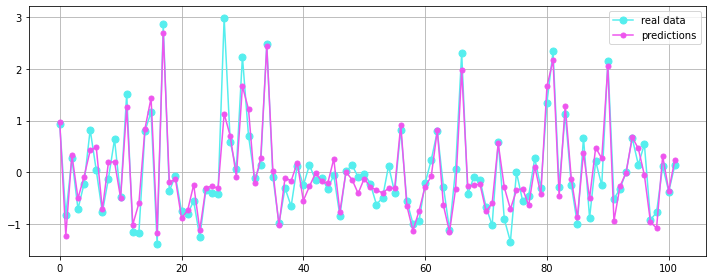

In [19]:
pl.figure(figsize=(10,4))
pl.plot(range(len(dfn_test)),dfn_test['MEDV'],
        '-o',label='real data',c='#55eeee',ms=7)
pl.plot(range(len(dfn_test)),py_test,
        '-o',label='predictions',c='#ee55ee',ms=5)
pl.tight_layout(); pl.grid(); pl.legend();